### 서버에서 Selenium 사용하기
- 크롬 브라우저 설치
    - `sudo apt-get install -y chromium-browser` : 서버에 크롬 브라우저 설치
    - `chromium-browser -version` : 드라이버와 버전을 맞추기 위해 버전 확인(80.0.3987.87)
- 크롬 드라이버 다운로드
    - `wget https://chromedriver.storage.googleapis.com/80.0.3987.106/chromedriver_linux64.zip` (터미널)
    - 압축해제프로그램 설치: `sudo apt install unzip`
    - 압축해제 : `unzip (프로그램.zip)`
    
    
- selenium 패키지 설치


In [7]:
!pip install pillow

You are using pip version 18.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
from selenium import webdriver
from PIL import Image as pil

In [13]:
options = webdriver.ChromeOptions()
options.add_argument('headless')
options.add_argument('window-size=1920x1080')
driver = webdriver.Chrome(options = options)

In [14]:
driver.get('https://naver.com')
driver.save_screenshot('naver_main.png')
driver.quit()

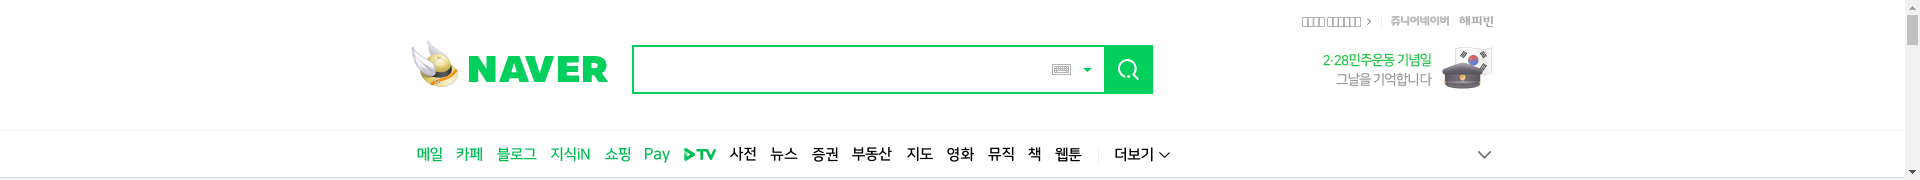

In [15]:
pil_img = pil.open('naver_main.png')
pil_img

#### 한글 깨짐 문제 해결하기 : 한글폰트 설치
- 명령어: `sudo apt-get install -y fonts-nanum*`


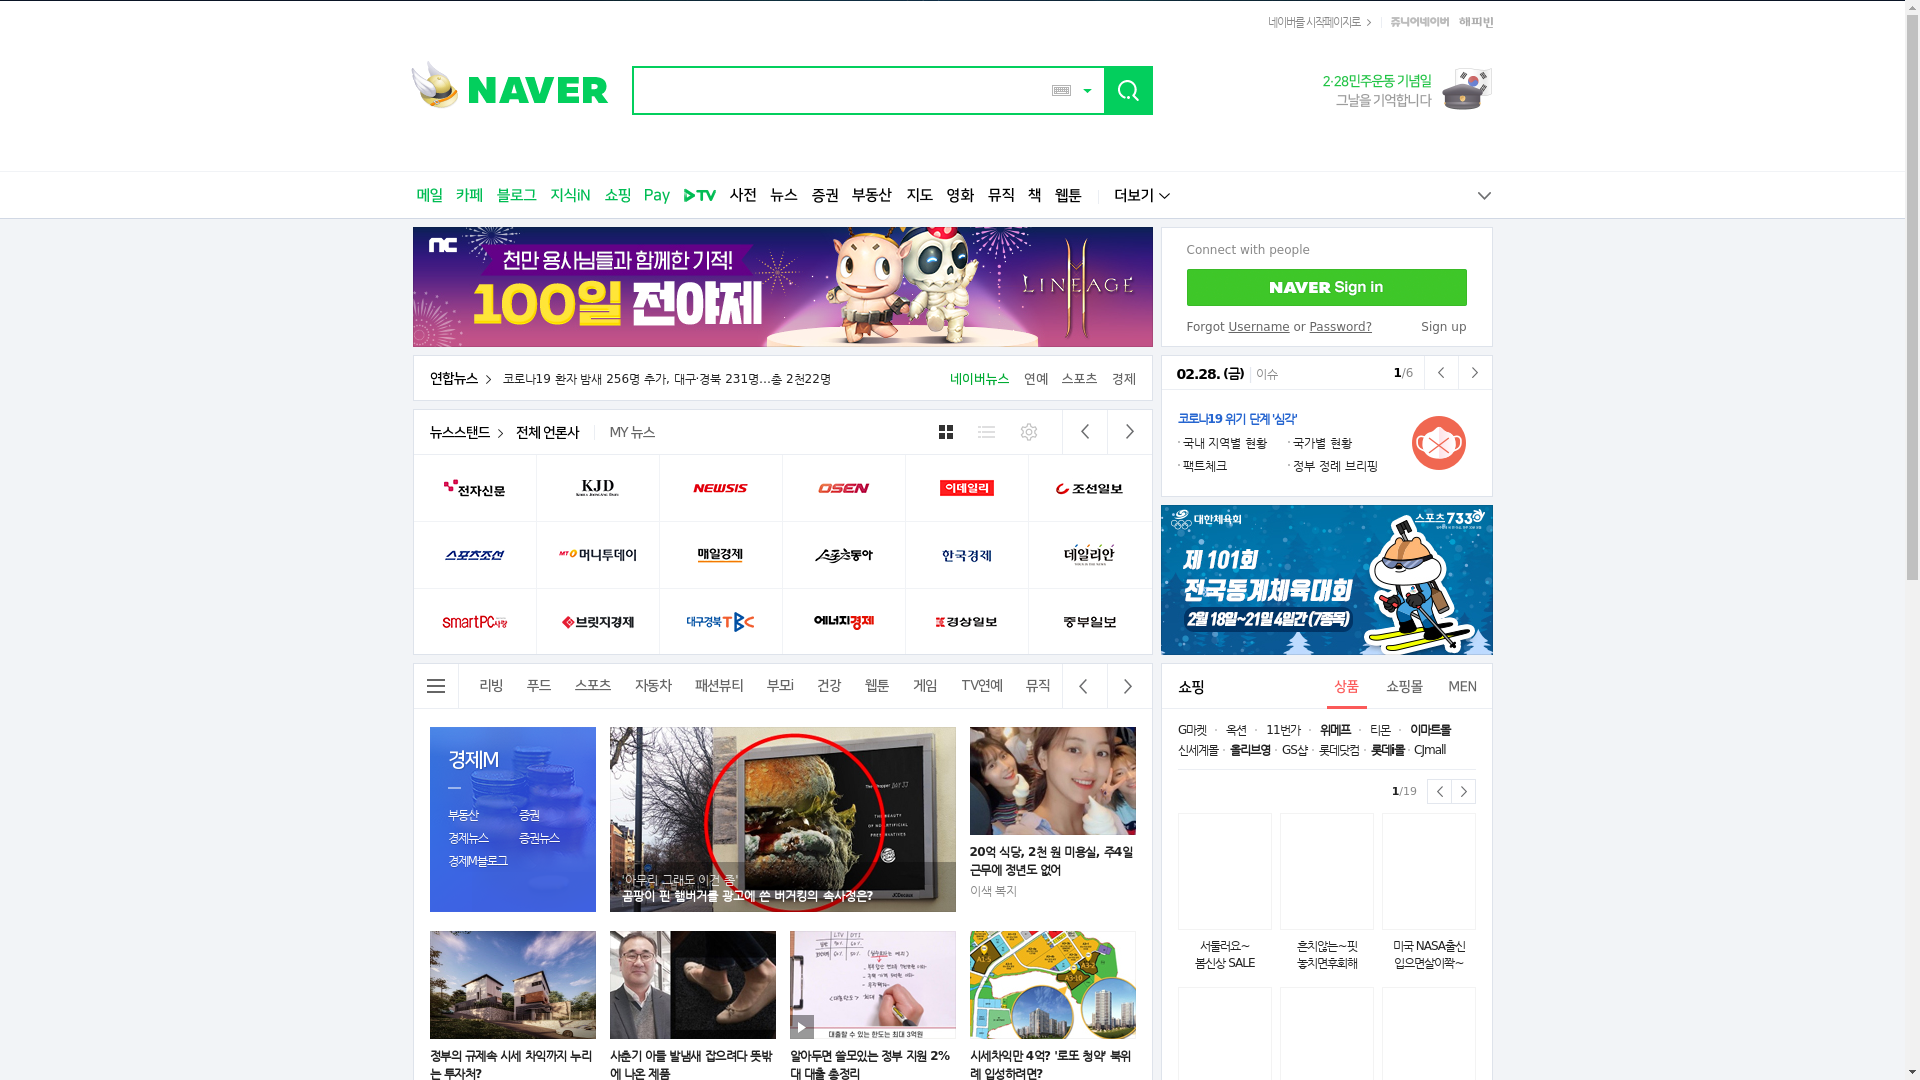

In [17]:
options = webdriver.ChromeOptions()
options.add_argument('headless')
options.add_argument('window-size=1920x1080')
driver = webdriver.Chrome(options = options)
driver.get('https://naver.com')
driver.save_screenshot('naver_main.png')
driver.quit()
pil_img = pil.open('naver_main.png')
pil_img

### 네이버 속보

In [23]:
category = {
    100: '정치',
    101: '경제',
    102: '사회',
    103: '생활/문화',
    104: '세계',
    105: 'IT/과학'
}

In [63]:
category = '100'
date = '20200228'
page = '1'

url = 'https://news.naver.com/main/list.nhn?\
mode=LSD&mid=sec&sid1={}&date={}&page={}'.format(category, date, page)

In [64]:
print(url)

https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1=100&date=20200228&page=1


In [65]:
driver = webdriver.Chrome(options = options)
driver.get(url)

In [66]:
articles = driver.find_elements_by_css_selector('.list_body.newsflash_body > ul > li')
len(articles)


20

In [67]:
articles[0].find_element_by_css_selector('dt:not(.photo)').text

'승객 태운 택시, 버스전용차선 이용하게 하자고요?[조미현의 국회 삐뚤게 보기]'

In [70]:
articles[0].find_element_by_css_selector('dt:not(.photo) > a').get_attribute('href')

'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=015&aid=0004298206'

In [78]:
table = []
for article in articles:
    table.append({
        'Title' : article.find_element_by_css_selector('dt:not(.photo)').text,
        'Link' : article.find_element_by_css_selector('dt:not(.photo) > a').get_attribute('href')
    })
table

[{'Title': '승객 태운 택시, 버스전용차선 이용하게 하자고요?[조미현의 국회 삐뚤게 보기]',
  'Link': 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=015&aid=0004298206'},
 {'Title': "정부 '통일이해 교재' 발간…독일 교훈 신설·北인권 일부 지적",
  'Link': 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=277&aid=0004633240'},
 {'Title': '기자회견 마친 안철수',
  'Link': 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=001&aid=0011435097'},
 {'Title': '기자회견 마친 안철수',
  'Link': 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=001&aid=0011435095'},
 {'Title': '신종 코로나 군 내 확진자 26명… 공군 간부 1명 추가',
  'Link': 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=469&aid=0000471896'},
 {'Title': "정봉주 '열린민주당' 창당",
  'Link': 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=001&aid=0011435093'},
 {'Title': "'110일만의 재회' 文대통령-여야대표 코로나19 합의문 마련할까",
  'Link': 'https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=277&aid=0004633237'},
 {'Title': '물마시

In [81]:
import pandas as pd
df = pd.DataFrame(table)[['Title', 'Link']]

In [119]:
import requests
response = requests.get(df.Link[0])
response

<Response [200]>

In [130]:
from bs4 import BeautifulSoup as bs
from selenium import webdriver
import pandas as pd
import requests

def get_news(category, date, page):
    options = webdriver.ChromeOptions()
    options.add_argument('headless')
    url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1={}&date={}&page={}'.format(category, date, page)
    driver = webdriver.Chrome(options = options)
    driver.get(url)
    articles = driver.find_elements_by_css_selector('.list_body.newsflash_body > ul > li')
    
    table = []
    
    for article in articles:
        title = article.find_element_by_css_selector('dt:not(.photo)').text
        links = article.find_element_by_css_selector('dt:not(.photo) > a').get_attribute('href')
        response = requests.get(links)
        html = bs(response.content, 'html.parser')
        text = html.select_one('#articleBodyContents').text.split('{}')[1].strip()
        
        table.append({
            'Title' : title,
            'Link' : links,
            'Text' : text
        })
    driver.quit()
    return pd.DataFrame(table)

In [ ]:
get_news(100, 20200228, 1)

In [112]:
text = html.select_one('#articleBodyContents').text.strip()

In [125]:
response = requests.get(link)
html = bs(response.content, 'html.parser')
text = html.select_one('#articleBodyContents').text.strip()
text.split('{}')[1].strip()

"북한 조선중앙TV는 신종 코로나바이러스 감염증(코로나19) 예방 조치로 주민들에 대한 검병검진을 철저하게 하고 있다고 지난 27일 보도했다. 사진은 중앙TV 방송화면으로, 마스크를 낀 주민이 체온측정을 받고 있다. [연합뉴스]       신종 코로나바이러스 감염증(코로나19)과 관련, 지난 24일 유엔으로부터 대북 제재 면제를 받은 국제적십자사연맹(IFRC)의 지원 물품이 공개됐다.      28일 유엔 안보리 홈페이지에 따르면 대북 지원 물품은 모두 8개 항목으로, 코로나19 감염 진단 물품이 3종류, 개인보호용품이 5종류다.      진단 물품은 유전자 증폭 검사장비(RT PRC) 1대, 검사에 소요되는 시약 1만 세트, 적외선 체온계 1000개 등이다.      개인보호 용품은 장갑이 1만 매로 가장 많다. 이어 의료용 마스크 4000개, 일회용 가운과 보안경이 각각 200개씩 지원된다.      이번 대북 지원 물품은 모두 유럽산이며, 항공편을 통해 북한으로 전달될 예정이다. 북한이 최근 평양과 러시아 블라디보스토크 간 고려항공의 왕복 노선 운항을 재개한 것으로 확인돼 러시아를 통한 전달 가능성이 나온다.      북한 최고인민회의 대의원들과 상임위원회 일꾼들이 백두산지구 혁명전적지 답사행군을 성과적으로 마쳤다고 노동당 기관지 노동신문이 28일 보도했다. 답사자들은 '신종 코로나바이러스 감염증'(코로나19)의 영향으로 모두 마스크를 착용하고 있다. [연합뉴스]       북한은 지난달 31일 코로나19 확산 차단을 위해 국제사회와 연결된 모든 육·해·공 통로를 차단했다.      유엔 대북 제재위원회는 26일엔 프랑스에 본부를 둔 인도주의 단체인 국경없는 의사회(MSF)가 신청한 코로나19 구호물품에 대한 제재 면제 물품도 공개했다. 의료용 고글 800여개와 면봉 1000여 개, 검사용 의료장비 등을 북한 보건성에 지원할 것이라고 명시했다.      유엔 대북 제재위는 “북한 내 주민들의 인권 보호 등을 위한 인도주의 활동까지 제재받지 않도록 하는 내

In [ ]:
table = []
    
for article in articles:
        table.append({
            'Title' : article.find_element_by_css_selector('dt:not(.photo)').text,
            'Link' : article.find_element_by_css_selector('dt:not(.photo) > a').get_attribute('href')
        })
    df = df.DataFrame(table)